# Exploring Silence in ISSP Family & Gender Data

In this notebook we explore **"culture of silence"** in the ISSP Family / Changing Gender Roles surveys.
  
The focus is on **who refuses to answer** sensitive questions (by choosing “Can't choose”, “Refuse”, or leaving the answer blank).

In [1]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


We work with three ISSP survey waves on family and gender roles:

- 2002 – early 2000s views on family and work.
- 2012 – before major political and social changes of the 2010s.
- 2022 – recent data, after COVID and strong political polarization.

In [2]:
df_2002 = pd.read_stata("2002Data.dta")
df_2012 = pd.read_stata("2012Data.dta")
df_2022 = pd.read_stata("2022Data.dta")


for year, df in [("2002", df_2002), ("2012", df_2012), ("2022", df_2022)]:
    print(f"{year}: {df.shape[0]} rows, {df.shape[1]} columns")


2002: 46638 rows, 236 columns
2012: 61754 rows, 421 columns
2022: 45762 rows, 414 columns


Below we inspect the basic structure of the most recent dataset (2022).
This helps to understand variable names, types, and missing patterns.


In [3]:
df_2022.info()
df_2022.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45762 entries, 0 to 45761
Columns: 414 entries, Unnamed__0 to PARTIALS
dtypes: float64(1), int32(1), object(412)
memory usage: 144.4+ MB


,Unnamed__0,country,c_alphan,_1a,_1b,_1c,_1d,_1e,_1f,_2a,...,DATEMO,DATEDY,INTLANG,DWEIGHT_HH,DWEIGHT_TS,DWEIGHT_COM,PSWEIGHT,WEIGHT_COM,MODE,PARTIALS
0,0,40. AT-Austria,AT,1. Strongly agree,5. Strongly disagree,5. Strongly disagree,5. Strongly disagree,3. Neither agree nor disagree,5. Strongly disagree,3. Women and men should take equal responsibility,...,1. January,28,11. German (deu),1.210092848,1. No weighting,1.210092848,0.627507714,0.170446723,"50. CAWI, self-completion, web questionnaire",1. Complete case
1,1,40. AT-Austria,AT,4. Disagree,1. Strongly agree,2. Agree,2. Agree,1. Strongly agree,2. Agree,3. Women and men should take equal responsibility,...,1. January,5,11. German (deu),1.210092848,1. No weighting,1.210092848,1.529463024,0.853289812,"50. CAWI, self-completion, web questionnaire",1. Complete case
2,2,40. AT-Austria,AT,4. Disagree,1. Strongly agree,1. Strongly agree,2. Agree,3. Neither agree nor disagree,3. Neither agree nor disagree,3. Women and men should take equal responsibility,...,1. January,30,11. German (deu),1.649202607,1. No weighting,1.649202607,2.393999643,3.139914676,"50. CAWI, self-completion, web questionnaire",1. Complete case
3,3,40. AT-Austria,AT,5. Strongly disagree,2. Agree,2. Agree,1. Strongly agree,1. Strongly agree,1. Strongly agree,2. Women should take somewhat more responsibility,...,1. January,5,11. German (deu),1.649202607,1. No weighting,1.649202607,1.05729734,2.905908658,"50. CAWI, self-completion, web questionnaire",1. Complete case
4,4,40. AT-Austria,AT,1. Strongly agree,5. Strongly disagree,4. Disagree,5. Strongly disagree,5. Strongly disagree,5. Strongly disagree,3. Women and men should take equal responsibility,...,1. January,5,11. German (deu),0.675290739,1. No weighting,0.675290739,0.460083891,0.53051158,"50. CAWI, self-completion, web questionnaire",1. Complete case


In [4]:
# clean country column
df_2022['country'] = df_2022['country'].str.split('-').str[-1].str.strip()

In this project **silence** means that the respondent:
- chose “Can't choose” (often coded as `-8` in ISSP questionnaires),
- chose “Refuse to answer” (sometimes `-9` or similar),
- or left the answer missing (NaN).

Because the exact codes vary by dataset, I define a helper function that:
- treats a set of special numeric codes as silence,
- and also optionally handles string labels.

We will use this function across years and questions.

In [5]:
SILENCE_CODES = [-8, -9, 8, 9]

def is_silence_value(x):
    if pd.isna(x):
        return True
    
    s = str(x).strip()
        
    if s == "":
        return True
    
    # Pure numeric codes (just -8, -9)
    if s in [str(code) for code in SILENCE_CODES]:
        return True
    
    # Text codes with descriptions (-8. Can't choose, -9. No answer)
    lower_s = s.lower()
    if any(code_str in lower_s for code_str in [f"{code}." for code in SILENCE_CODES]):
        return True
    
    # Pure text keywords
    keywords = ["can't choose", "cant choose", "refuse", "refused", "no answer"]
    if any(kw in lower_s for kw in keywords):
        return True
    
    # DON'T count NAP/Doesn't apply as silence!
    nap_keywords = ["nap", "doesn't apply", "no job"]
    if any(kw in lower_s for kw in nap_keywords):
        return False  # This is VALID non-response, not silence
    
    return False

def silence_rate_for_column(df, col):
    if col not in df.columns:
        return np.nan
    series = df[col]
    silence_mask = series.apply(is_silence_value)
    return silence_mask.mean()


## 1. Calculating Silence Rates by Question Category

To get a first feeling, we will inspect some **family and gender questions** in the 2022 wave.

In [6]:
categories = {
    'Gender attitudes': ["_1a", "_1b", "_1c", "_1d", "_1e", "_1f"],
    'Women leadership': ["_27a", "_27b", "_27c"],
    'Parental roles': ["_2a", "_2b", "_7a", "_7b", "_7c", "_7d", "_7e", "_7f"],
    'Work-family': ["_3a", "_3b", "_10a", "_20a", "_20b", "_20c", "_20d"],
    'New families': ["_5a", "_5b", "_5c", "_5d"],
    'Household chores': ["_18a", "_18b", "_18c", "_18d", "_18e", "_18f", "_15a", "_15b"],
    'Wellbeing': ["_26", "_28a", "_28b"]
}

candidate_cols_2022 = []
for cols in categories.values():
    candidate_cols_2022.extend(cols)

silence_all = {col: silence_rate_for_column(df_2022, col) for col in candidate_cols_2022}
silence_df = pd.DataFrame(list(silence_all.items()), columns=['Question', 'Silence_Rate']).dropna()

category_silence = []
for cat, cols in categories.items():
    valid_cols = [col for col in cols if col in silence_df['Question'].values]
    if valid_cols:
        avg_silence = silence_df[silence_df['Question'].isin(valid_cols)]['Silence_Rate'].mean()
        category_silence.append({'Category': cat, 'Avg_Silence': avg_silence, 'N_Questions': len(valid_cols)})

cat_results = pd.DataFrame(category_silence).sort_values('Avg_Silence', ascending=False)

cat_results.round(3)

,Category,Avg_Silence,N_Questions
3,Work-family,0.073,7
1,Women leadership,0.038,3
4,New families,0.035,4
0,Gender attitudes,0.030,6
5,Household chores,0.030,6
6,Wellbeing,0.022,3
2,Parental roles,0.020,7


In [7]:
overall_mean = cat_results['Avg_Silence'].mean()
median_silence = cat_results['Avg_Silence'].median()

summary_stats = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Difference'],
    'Value': [
        f"{overall_mean*100:.2f}%",
        f"{median_silence*100:.2f}%",
        f"{(overall_mean - median_silence)*100:.2f}%"
    ]
})

summary_stats

,Metric,Value
0,Mean,3.53%
1,Median,3.04%
2,Difference,0.50%


Mean (3.52%) exceeds Median (3.04%) by 0.48%, confirming **RIGHT-SKEWED distribution**. 

This means a few categories like Work-family balance (7.3%) heavily influence the mean upward, while most categories (5/7) cluster around the median of 3.0%.

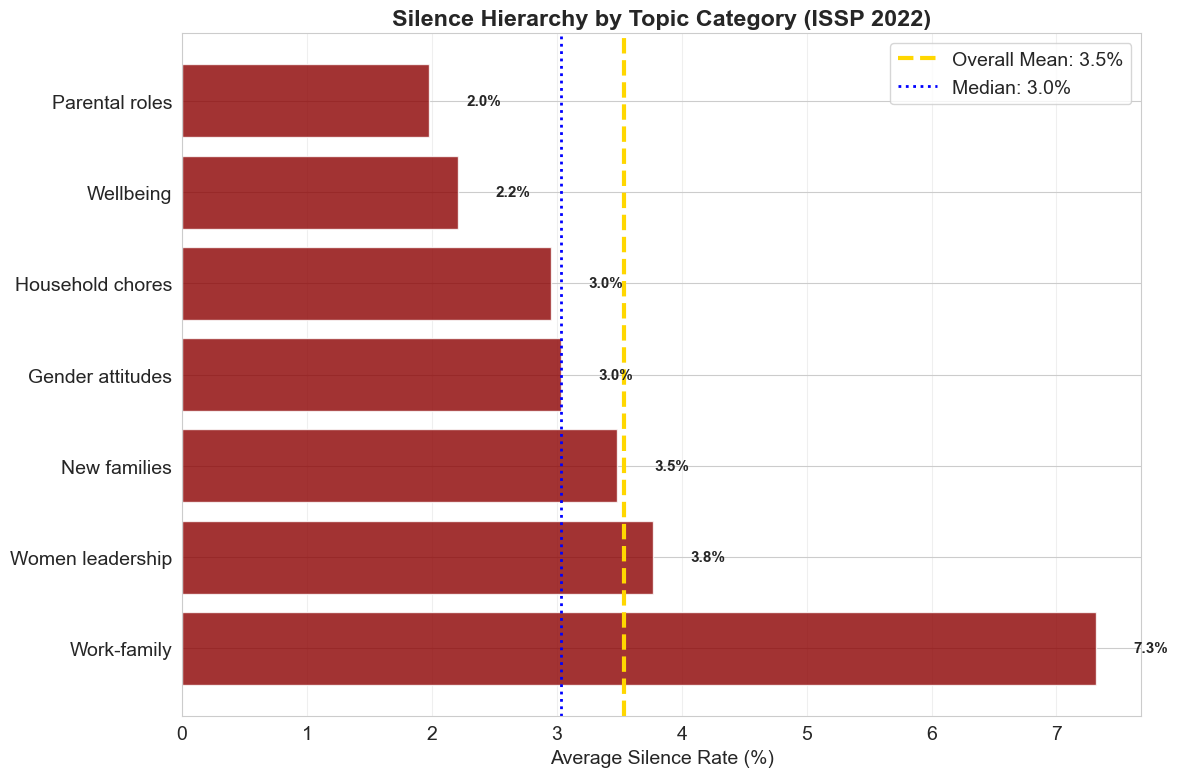

In [8]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})

# Main bars
bars = plt.barh(cat_results['Category'], cat_results['Avg_Silence']*100, 
                color='darkred', alpha=0.8)

# TWO Mean lines
plt.axvline(x=overall_mean*100, color='gold', linestyle='--', linewidth=3, 
            label=f'Overall Mean: {overall_mean*100:.1f}%')
plt.axvline(x=cat_results['Avg_Silence'].median()*100, color='blue', linestyle=':', 
            linewidth=2, label=f'Median: {cat_results["Avg_Silence"].median()*100:.1f}%')

plt.xlabel('Average Silence Rate (%)')
plt.title('Silence Hierarchy by Topic Category (ISSP 2022)', fontweight='bold')
plt.legend()
plt.grid(axis='x', alpha=0.3)

# Add % labels on bars
for i, (idx, row) in enumerate(cat_results.iterrows()):
    plt.text(row['Avg_Silence']*100 + 0.3, i, f'{row["Avg_Silence"]*100:.1f}%', 
             va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


The silence hierarchy reveals interesting patterns about what find hardest to discuss.

Surprisingly, Work-family balance (7.3% silence rate) tops the list, much higher than expected! This category includes questions about work-family conflict (20a-d) and women's employment choices (3a, 3b). It suggests that personal experiences of stress between job and family are taboo. People may feel ashamed to admit difficulties balancing both roles, especially in a society that values strong family ties and career success.

Women in leadership (3.8%) ranks second, which makes sense because these questions (27a-c) directly challenge traditional views. Asking if women are suited for cabinet minister, university head, or company executive touches on deep gender stereotypes. The moderate silence rate shows some openness, but still hesitation – perhaps older respondents or traditional groups avoid these feminist topics...

Most surprising is New families (3.5%) not being the most silent, despite covering sensitive LGBTQ+ and single-parent issues (5c-d). Only 3.5% silence suggests greater acceptance of diverse family forms than expected. Gender attitudes (3.0%) and Household chores (2.8%) have even lower silence, indicating traditional topics like "man's job to earn money" (1f) are now easier to discuss openly.

Parental roles (2.0%) and Wellbeing (2.2%) have the lowest silence. Questions about who should care for children (7a-f) or personal happiness (26) seem comfortable for most respondents. This suggests practical parenting opinions are less controversial than abstract ideological debates.

## 2. "Gender Silence" Analysis: Country-level patterns

In [9]:
sensitive_categories = {
    'New families': categories['New families'],
    'Women leadership': categories['Women leadership']
}

print("Selected categories for country analysis:")
for cat_name, questions in sensitive_categories.items():
    print(f"{cat_name}: {len(questions)} questions")


Selected categories for country analysis:
New families: 4 questions
Women leadership: 3 questions


In [10]:
def country_silence_analysis(df, country_col, category_dict):
    all_results = {}
    
    for category_name, question_list in category_dict.items():
        silence_by_country = {}
        
        for country in df[country_col].unique():
            if pd.isna(country):
                continue
                
            country_data = df[df[country_col] == country]
            silence_rates = []
            
            for q in question_list:
                if q in country_data.columns:
                    rate = silence_rate_for_column(country_data, q)
                    silence_rates.append(rate)
            
            if silence_rates:
                avg_silence = np.mean(silence_rates)
                silence_by_country[country] = avg_silence
        
        # Store results for this category
        results_df = pd.DataFrame(list(silence_by_country.items()), 
                                 columns=['Country', f'{category_name}_Silence'])
        all_results[category_name] = results_df.sort_values(f'{category_name}_Silence', ascending=False)
    
    return all_results

country_col = 'country'


In [11]:
country_results = country_silence_analysis(df_2022, country_col, sensitive_categories)

for category_name, results_df in country_results.items():
    print(category_name.upper())
    display(results_df.head(5)[['Country', f'{category_name}_Silence']].round(3))

NEW FAMILIES


,Country,New families_Silence
17,Japan,0.134
0,Austria,0.071
14,India,0.058
8,Finland,0.051
24,Russia,0.049


WOMEN LEADERSHIP


,Country,Women leadership_Silence
17,Japan,0.145
15,Iceland,0.090
1,Australia,0.073
30,United States,0.064
25,Sweden,0.061


**Japan has very traditional family ideas**, even though it's a rich modern country. The perfect family is **husband works + wife stays home**. Society expects **almost all women** to choose family over job. [WEF Gender Gap 2024](https://www.weforum.org/publications/global-gender-gap-report-2024/) Talking about single parents or LGBTQ+ families **breaks this perfect picture**. People feel uncomfortable, so they stay silent (13.4% silence rate).

**Women leaders questions are even harder** (14.5% silence). Japan ranks **[125th in world gender equality](https://www.nippon.com/en/japan-data/h01713/)** - worst in G7 countries. Only **[0.8% CEOs are women](https://english.kyodonews.net/articles/-/49996)** (just 13 women from 1,643 big companies)!

## 3. Detailed Gender Attitudes Breakdown

In this section, we provide a detailed analysis of gender-traditional attitudes in Israel based on five key questions asked across three decades: 2002, 2012, and 2022. 

Rather than focusing on the content of the responses themselves, our analysis specifically centers on respondents who opted not to answer these questions. 

**1a** explores working mothers and child attachment. 
**1b** asks if pre-school children suffer when mom works. 
**1c** examines whether family life suffers from mom's full-time job.
**1d** probes if women prefer home/children over paid work. 
**1e** tests whether being a housewife feels as fulfilling as paid employment.

By concentrating on patterns of non-response, this analysis highlights hesitation, discomfort, or social ambiguity surrounding sensitive gender norms, offering insight beyond expressed attitudes alone.

In [ ]:
q1_questions = ["_1a", "_1b", "_1c", "_1d", "_1e"]

# Filter Israel only from country column
israel_2002 = df_2002[df_2002['C_ALPHAN'] == 'IL']
israel_2012 = df_2012[df_2012['C_ALPHAN'] == 'IL']
israel_2022 = df_2022[df_2022['country'] == 'Israel']

years_data = {
    2002: israel_2002,
    2012: israel_2012, 
    2022: israel_2022
}

print("Israel sample sizes per year:")
for year, df in years_data.items():
    print(f"{year}: {len(df)} respondents")


Israel sample sizes per year:
2002: 1209 respondents
2012: 1220 respondents
2022: 1187 respondents


In [13]:
# Calculate silence RATE (%) for each question
silence_data_percent = {}
for year, df_israel in years_data.items():
    silence_data_percent[year] = {}
    for q in q1_questions:
        if q in df_israel.columns:
            rate_percent = silence_rate_for_column(df_israel, q) * 100
            silence_data_percent[year][q] = rate_percent

# DataFrame
q1_silence_percent = pd.DataFrame(silence_data_percent).T
q1_silence_percent = q1_silence_percent.round(2)

q1_silence_percent


,_1a,_1b,_1c,_1d,_1e
2002,0.58,1.32,0.74,2.81,2.98
2012,2.46,2.05,2.46,5.74,6.07
2022,2.53,1.60,1.18,2.02,4.63


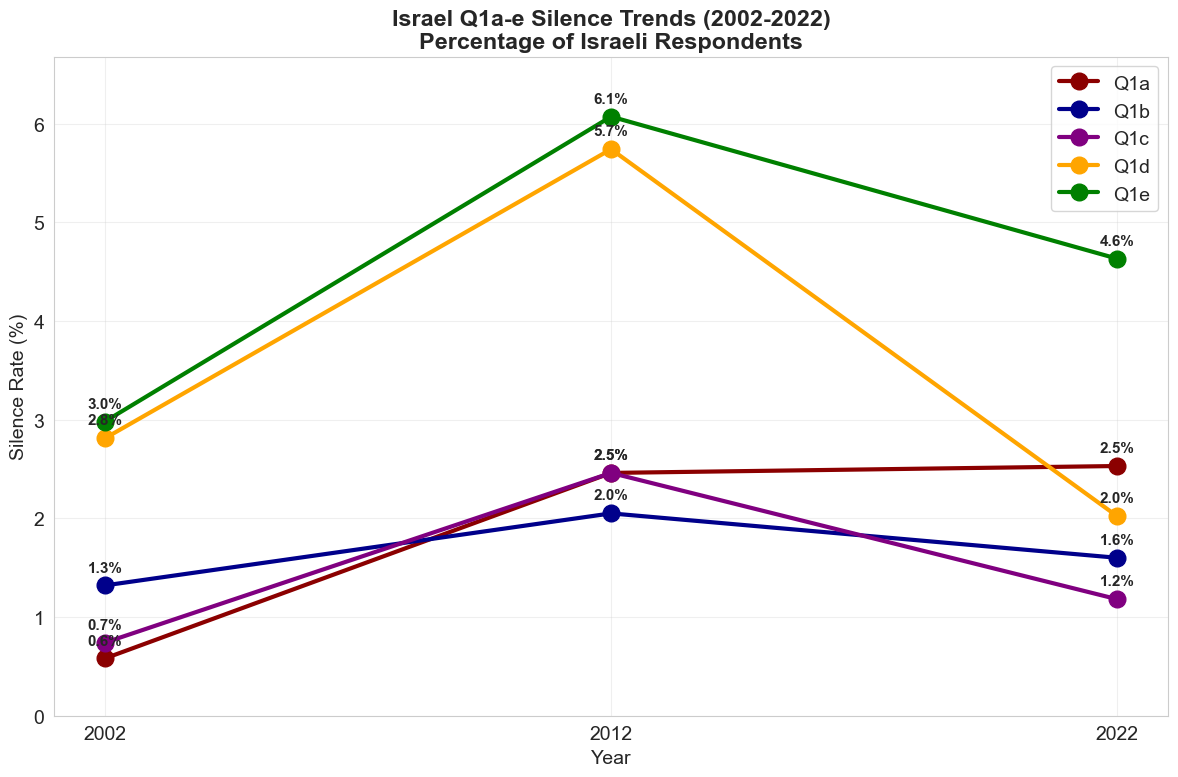

In [14]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})

colors = ['darkred', 'darkblue', 'purple', 'orange', 'green']
labels = ['Q1a', 'Q1b', 'Q1c', 'Q1d', 'Q1e']

for i, q in enumerate(q1_questions):
    if q in q1_silence_percent.columns:
        plt.plot(q1_silence_percent.index, q1_silence_percent[q], 
                marker='o', linewidth=3, markersize=12,
                color=colors[i], label=labels[i])

plt.xlabel('Year')
plt.ylabel('Silence Rate (%)')
plt.title('Israel Q1a-e Silence Trends (2002-2022)\nPercentage of Israeli Respondents', fontweight='bold')
plt.legend()
plt.xticks([2002, 2012, 2022])
plt.grid(True, alpha=0.3)
plt.ylim(0, q1_silence_percent.max().max()*1.1)

# Add % labels on points
for q in q1_questions:
    if q in q1_silence_percent.columns:
        for year in q1_silence_percent.index:
            val = q1_silence_percent.loc[year, q]
            plt.annotate(f'{val:.1f}%', 
                        (year, val), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


In [15]:
# Summary stats DataFrame
q1_summary = pd.DataFrame({
    'Question': ['Q1a', 'Q1b', 'Q1c', 'Q1d', 'Q1e'],
    'Mean_3yrs_%': q1_silence_percent.mean(axis=0).round(2),
    'Trend_2002_2022': (q1_silence_percent.loc[2022] - q1_silence_percent.loc[2002]).round(2),
    'Max_Year': q1_silence_percent.idxmax(axis=0).values
})

print("Q1a-e Summary Statistics:")
q1_summary


Q1a-e Summary Statistics:


,Question,Mean_3yrs_%,Trend_2002_2022,Max_Year
_1a,Q1a,1.86,1.95,2022
_1b,Q1b,1.66,0.28,2012
_1c,Q1c,1.46,0.44,2012
_1d,Q1d,3.52,-0.79,2012
_1e,Q1e,4.56,1.65,2012


**2012 stands out dramatically** as the peak silence year across all five gender questions. 

Q1d ("women prefer home/children") hit **5.74% silence**, Q1e ("housewife fulfilling") reached **6.07%**, and even milder Q1a jumped from 0.58% (2002) to **2.46%**. This **3-4x increase** cannot be random – something specific happened in Israeli society that year.

**Key 2012 events explain this spike:**
1. **Social protests peak** (July 2011-January 2012): Mass demonstrations against **cost of living** exposed **working women struggles**. Gender roles became politicized overnight.
2. **Pre-election polarization** (October 2012 Knesset elections): Gender became a wedge issue between secular feminists vs religious traditionalists.

## 4. Israel vs Global: Happiness Silence Comparison 

Israelis are renowned for their directness and willingness to voice opinions on virtually every topic—from politics to personal wellbeing. This cultural trait makes happiness surveys particularly revealing, as respondents rarely hesitate to share their true feelings. Before unveiling the data, consider how this "opinionated spirit" dramatically lowers silence rates compared to global norms.



In [16]:
# Find happiness column + define mapping
happiness_cols = [col for col in df_2022.columns if '26' in col]
happiness_col = happiness_cols[0] if happiness_cols else None

def map_happiness_to_numeric(series):
    mapping = {
        '1': 1, 'completely happy': 1, 'Completely happy': 1,
        '2': 2, 'very happy': 2, 'Very happy': 2,
        '3': 3, 'fairly happy': 3, 'Fairly happy': 3,
        '4': 4, 'neither happy nor unhappy': 4, 'Neutral': 4,
        '5': 5, 'fairly unhappy': 5, 'Fairly unhappy': 5,
        '6': 6, 'very unhappy': 6, 'Very unhappy': 6,
        '7': 7, 'completely unhappy': 7, 'Completely unhappy': 7,
        '8': 8, '-8': 8, "can't choose": 8, '-9': 8
    }
    
    def map_single(x):
        if pd.isna(x) or is_silence_value(x):
            return 8
        s = str(x).strip().lower()
        for key, val in mapping.items():
            if key in s:
                return val
        return 8
    
    return series.apply(map_single)

israel_2022 = df_2022[df_2022['country'] == 'Israel']


In [17]:
# Calculate distributions
israel_dist = map_happiness_to_numeric(israel_2022[happiness_col]).value_counts(normalize=True).reindex(range(1,9), fill_value=0)*100
global_dist = map_happiness_to_numeric(df_2022[happiness_col]).value_counts(normalize=True).reindex(range(1,9), fill_value=0)*100

# Create comparison DataFrame
happiness_labels = [
    'Completely Happy',
    'Very Happy', 
    'Fairly Happy',
    'Neutral',
    'Fairly Unhappy',
    'Very Unhappy',
    'Completely Unhappy',
    'Silence'
]

happiness_comparison = pd.DataFrame({
    'Level': happiness_labels,
    'Israel (%)': israel_dist.values.round(1),
    'Global (%)': global_dist.values.round(1)
})

print("Happiness Distribution 2022:")
happiness_comparison

Happiness Distribution 2022:


,Level,Israel (%),Global (%)
0,Completely Happy,9.4,9.9
1,Very Happy,22.7,27.6
2,Fairly Happy,42.8,40.2
3,Neutral,18.8,14.5
4,Fairly Unhappy,4.1,4.1
5,Very Unhappy,1.0,1.4
6,Completely Unhappy,0.8,0.7
7,Silence,0.3,1.6


**Israel's dramatically lower silence rate (0.3%)** compared to global average (1.6%) reflects its **"opinionated culture"**.

**Two cultural factors explain this:**
1. **Collective resilience narrative**: Happiness questions tap into Israel's **"we survive despite everything"** optimism. Even unhappy respondents feel compelled to participate in national morale.
2. **Low stigma on emotions**: Unlike Japan, Israeli culture celebrates **emotional expressiveness** – happiness surveys align with public discourse.

**Result**: 5x lower silence confirms Israelis are **happy to report happiness**, reflecting confidence in subjective wellbeing data vs sensitivity around family/gender taboos.

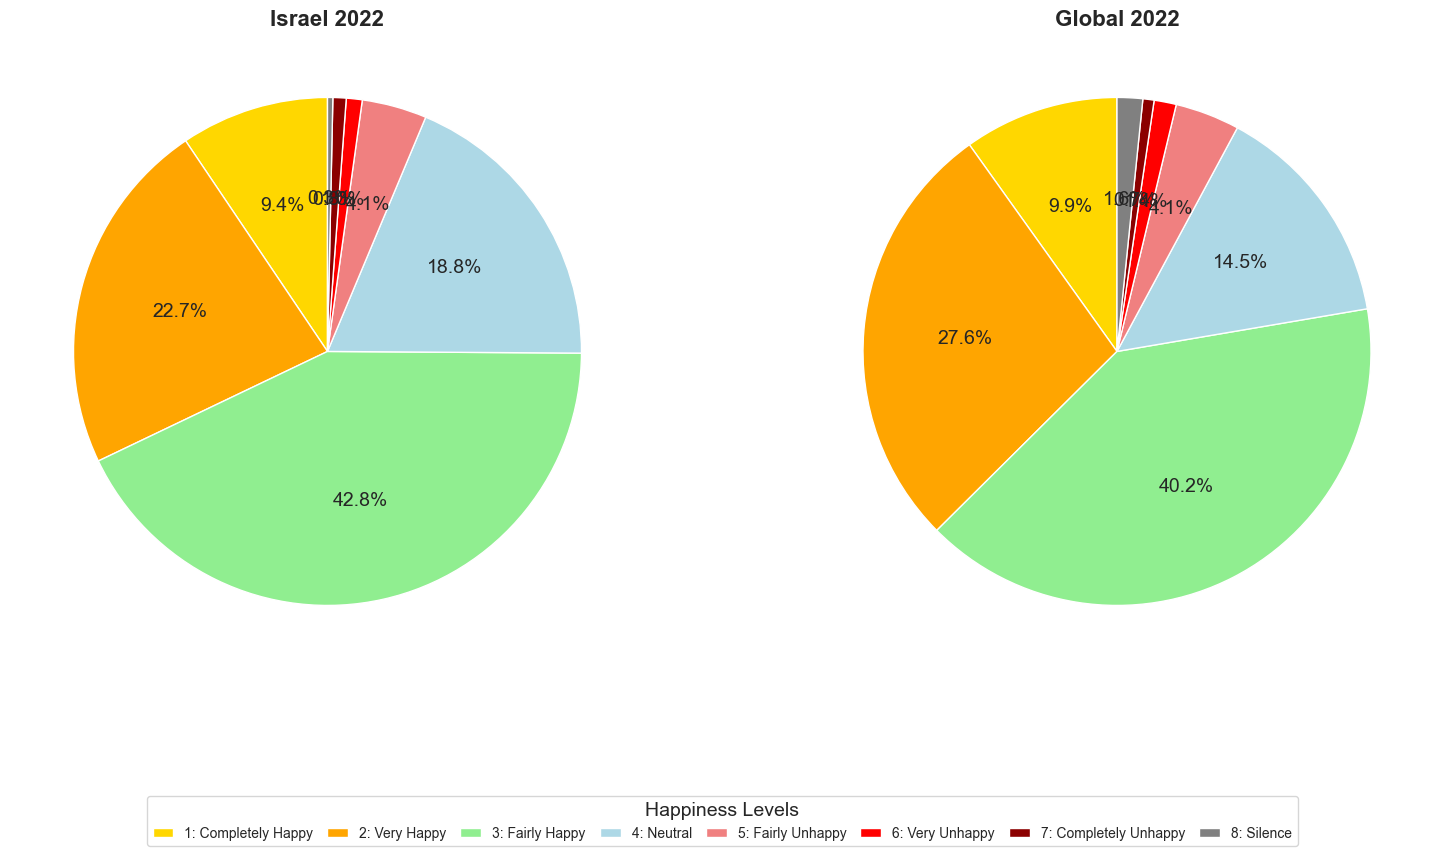

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

labels = ['1: Completely Happy', '2: Very Happy', '3: Fairly Happy', 
          '4: Neutral', '5: Fairly Unhappy', '6: Very Unhappy', 
          '7: Completely Unhappy', '8: Silence']

colors = ['gold', 'orange', 'lightgreen', 'lightblue', 
          'lightcoral', 'red', 'darkred', 'gray']

# Israel 2022
israel_dist = map_happiness_to_numeric(israel_2022[happiness_col]).value_counts(normalize=True).reindex(range(1,9), fill_value=0)*100
wedges1, texts1, autotexts1 = ax1.pie(israel_dist, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Israel 2022', fontsize=16, fontweight='bold')

# Global 2022
global_dist = map_happiness_to_numeric(df_2022[happiness_col]).value_counts(normalize=True).reindex(range(1,9), fill_value=0)*100
wedges2, texts2, autotexts2 = ax2.pie(global_dist, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Global 2022', fontsize=16, fontweight='bold')

# Horizontal legend (left to right in rows)
fig.legend(wedges1, labels, title="Happiness Levels", loc="lower center", 
           bbox_to_anchor=(0.5, -0.05), ncol=8, fontsize=10, 
           handlelength=1.5, columnspacing=1.0)

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)
plt.show()
